# Project: Identify Customer Segments

In this project, I will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.


In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I will use this information to cluster the general population into groups with similar demographic properties. Then, I will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so I'll need an additional argument in my [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that I take a little bit of time just browsing the general structure of the dataset and feature summary file. I'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help me get my bearings.

# Step 1. Read in database

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(azdias.info())

(891221, 85)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB     

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.filter(regex="^SEMIO", axis=1).head()

,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV
0,2,6,7,5,1,5,3,3,4,7,6,6,5,3
1,5,4,4,3,1,2,2,3,6,4,7,4,7,6
2,4,1,3,3,4,4,6,3,4,7,7,7,3,3
3,5,1,2,1,4,4,7,4,3,4,4,5,4,4
4,6,4,4,2,7,4,4,6,2,3,2,2,4,2


In [6]:
print(feat_info.shape)
feat_info.head()

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


#### My Note: 
1. As `azdias.info()` shows, there're some missing data in `azdias`. I'd creat a function to clean it later.
2. Except specific missing and unknown value, there're already some NaN in original dataset. But now I won't process it because we'd convert all specific missing and unknown value to NaN.
3. All data point in `feat_info` are object, that of in `azdias` are mixed int, float, and object.

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I will use this file to help myself make cleaning decisions during this stage of the project. First of all, I'd assess the demographics data in terms of missing data.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. I'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. I might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [8]:
def is_int(value):
  try:
    int(value)
    return True
  except ValueError:
    return False

In [9]:
# Befor covent
print(azdias['AGER_TYP'][1:5])
azdias['CAMEO_DEUG_2015'][2510:2515]

1   -1
2   -1
3    2
4   -1
Name: AGER_TYP, dtype: int64


2510    9
2511    X
2512    9
2513    5
2514    9
Name: CAMEO_DEUG_2015, dtype: object

In [10]:
# Identify missing or unknown data values and convert them to NaNs.

for i in range(azdias.shape[1]):
    att = feat_info.loc[i, 'attribute']
    tmp = feat_info.loc[i, 'missing_or_unknown'].strip('[]').split(',') # output tpye are list of string
    missing_unknow = [int(j) if is_int(j) == True else j for j in tmp] # convert number to int
    azdias.loc[:, att].replace(missing_unknow, np.nan, inplace = True)
    

In [11]:
# After convert
print(azdias['AGER_TYP'][1:5])
azdias['CAMEO_DEUG_2015'][2510:2515]

1    NaN
2    NaN
3    2.0
4    NaN
Name: AGER_TYP, dtype: float64


2510      9
2511    NaN
2512      9
2513      5
2514      9
Name: CAMEO_DEUG_2015, dtype: object

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. I will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project I'd just remove them from the dataframe. 

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Investigate patterns in the amount of missing data in each column.
nan_col = azdias.isnull().sum().sort_values(ascending = False)
nan_col[1:5]

AGER_TYP        685843
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
GEBURTSJAHR     392318
dtype: int64

In [13]:
# Remove the outlier columns from the dataset. (I'll perform other data
# engineering tasks such as re-encoding and imputation later.)
nan_table = pd.DataFrame(data = nan_col, columns = ['count'])
nan_table['percent'] = nan_table['count']/azdias.shape[0] *100
nan_table

,count,percent
TITEL_KZ,889061,99.757636
AGER_TYP,685843,76.955435
KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,476524,53.468668
GEBURTSJAHR,392318,44.020282
ALTER_HH,310267,34.813699
REGIOTYP,158064,17.735668
KKK,158064,17.735668
W_KEIT_KIND_HH,147988,16.605084
KBA05_ANTG4,133324,14.959701


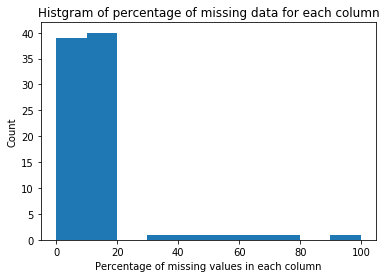

In [14]:
# How much percent missing data there is in each column of the dataset
plt.hist(nan_table['percent'])
plt.title('Histgram of percentage of missing data for each column')
plt.xlabel('Percentage of missing values in each column')
plt.ylabel('Count')
plt.show()

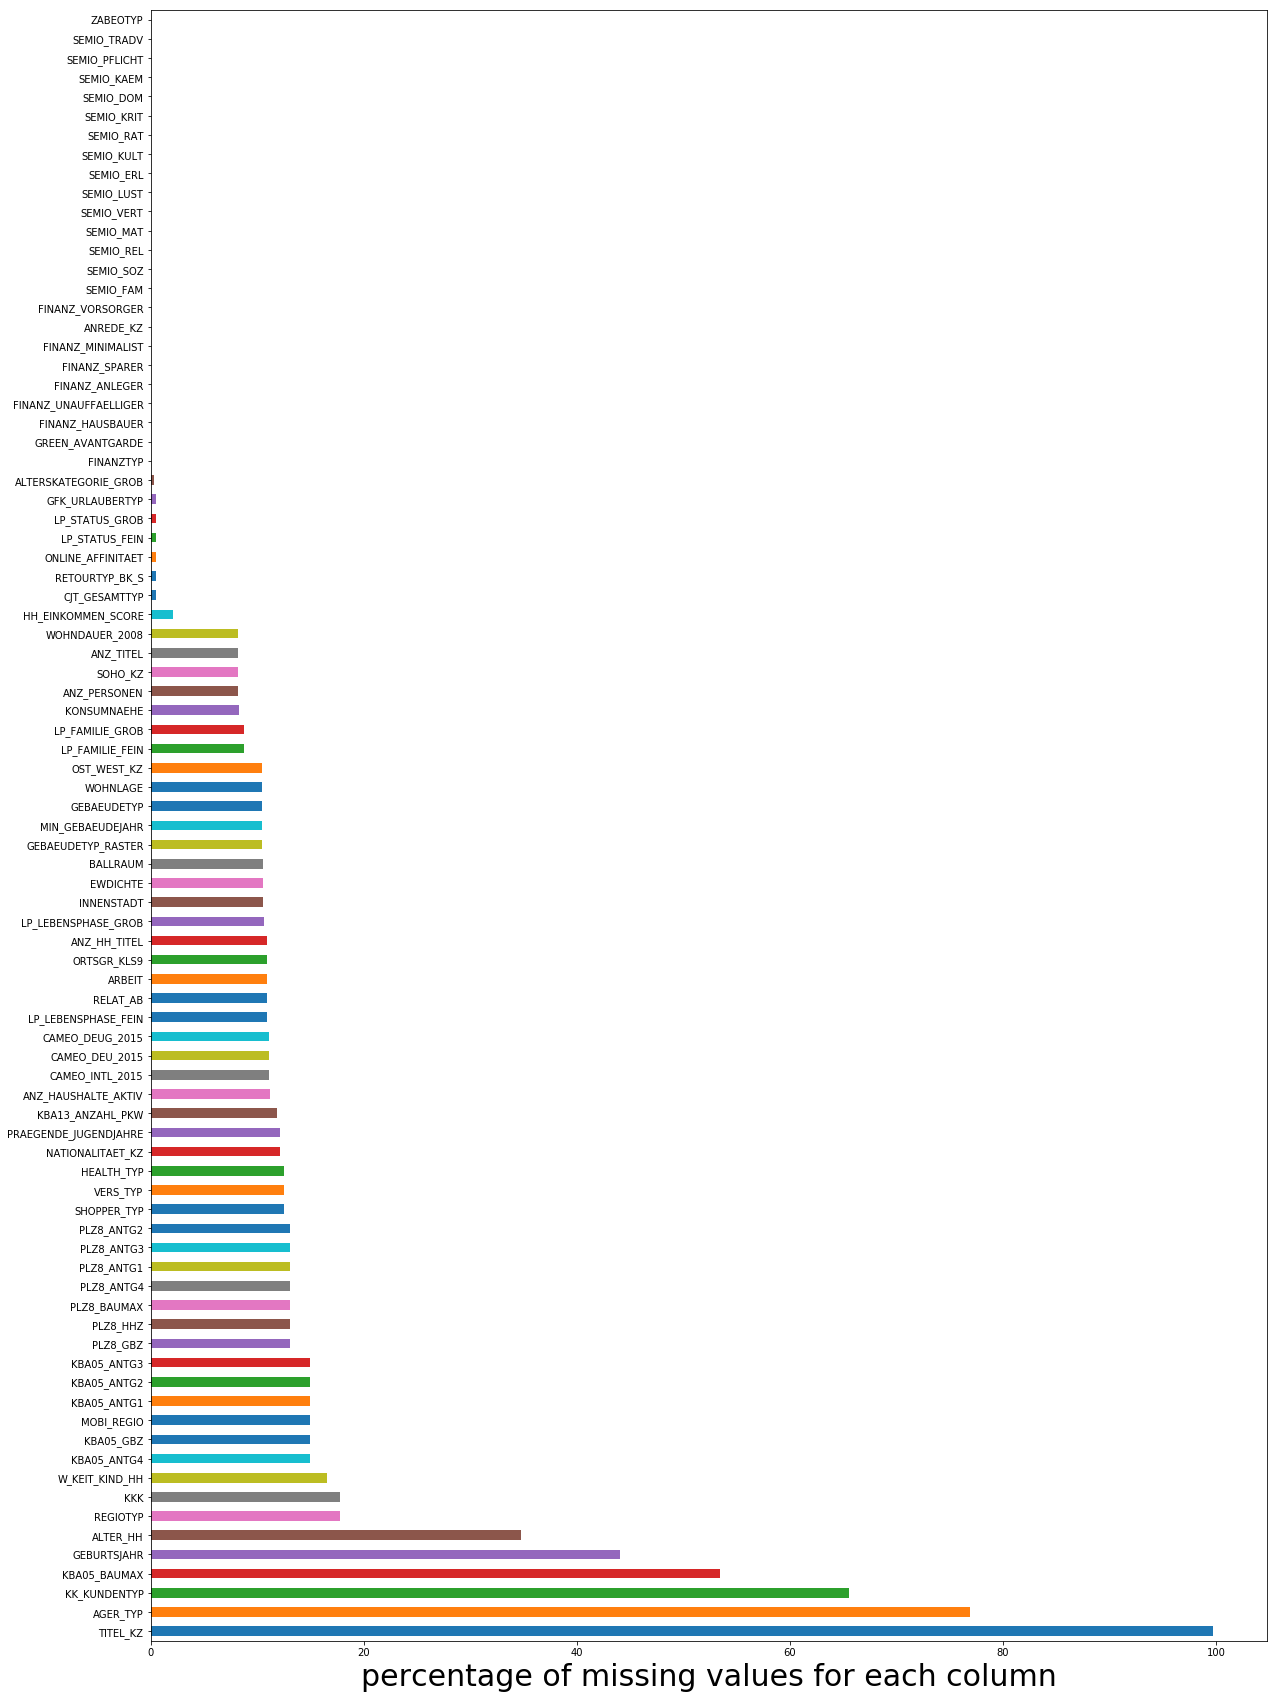

In [15]:
# Investigate patterns in the amount of missing data in each column.
nan_table['percent'].plot.barh(figsize = (20,30))
plt.xlabel('percentage of missing values for each column', fontsize = 30)
plt.show()

In [16]:
nan_table.describe()

,count,percent
count,85.000000,85.000000
mean,98516.811765,11.054139
std,146604.203317,16.449815
min,0.000000,0.000000
25%,0.000000,0.000000
50%,93148.000000,10.451729
75%,116515.000000,13.073637
max,889061.000000,99.757636


#### Pick out outliers:
I'd choose the percentage which greater than mean+std as outliers. Therefore,\
$mean + 2\times \sigma = 11.05 + 2 \times 16.45 = 43.95$\
Will remove those whose percentge of missing value is greater than 43.95

In [17]:
outlier_col = nan_table[nan_table['percent'] > 43.95].index
outlier_col

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR'], dtype='object')

In [18]:
# remove outlier
azdias.drop(columns=outlier_col, inplace=True)
azdias.shape

(891221, 80)

In [19]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

1. As $mean + 2\sigma$ contains 95% information, in this case, $mean + 2\sigma = 43.95$, such that I'd remove those whose percentage of missing data is greater than 43.95%. Therefore columns `TITEL_KZ`, `AGER_TYP`, `KK_KUNDENTYP`, `KBA05_BAUMAX`, and `GEBURTSJAHR` would be dropped.

2. Some columns have similar percentage of missing data, for instance, proportion of missing data in `PLZ8_` is 13.07%, that of in `KBA05` is 14.96%. Don't know if it would be useful in later analysis, we will see.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, I'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, I'd see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- I'd use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, I might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what I observe in my comparison, this will have implications on how I approach my conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, I should continue my analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?
# Investigate patterns in the amount of missing data in each column.
nan_row = azdias.isnull().sum(axis = 1).sort_values(ascending = False)

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
nan_table2 = pd.DataFrame(data = nan_row, columns = ['count'])
nan_table2['percent'] = nan_table2['count']/azdias.shape[1] *100
nan_table2[:10]

,count,percent
732775,49,61.25
643174,49,61.25
708330,48,60.00
701371,48,60.00
274725,48,60.00
274714,48,60.00
274686,48,60.00
274621,48,60.00
850053,48,60.00
274578,48,60.00


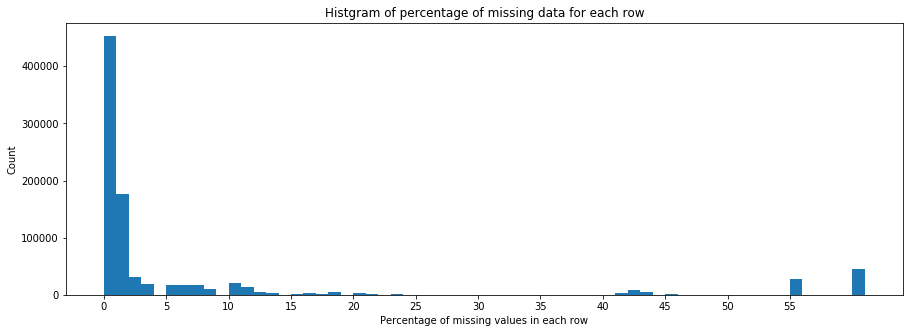

In [22]:
# Hist of missing values for rows
plt.figure(figsize=(15,5))
plt.hist(nan_table2['percent'], bins = np.arange(0, nan_table2['percent'].max(), 1))
plt.title('Histgram of percentage of missing data for each row')
plt.xlabel('Percentage of missing values in each row')
plt.ylabel('Count')
plt.xticks(np.arange(0, 60, 5))
plt.show()

In [23]:
nan_table2.describe()

,count,percent
count,891221.000000,891221.000000
mean,5.998031,7.497538
std,13.425635,16.782044
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,3.000000,3.750000
max,49.000000,61.250000


#### My Note: 
Similarly, I'd remove those whose percentage of missing data is greater than mean+2 sigma, in this case,\
$mean +2 * \sigma = 41$

Also, in figure `Histgram of percentage of missing data for each row`, we can see the histogram could be devided into two subsets by 40. In order to not overkill data, I'd choose `min(41, 40)` = 40 as my threshold.

In [24]:
# Select rows with more than 40% missing data
outlier_row = nan_table2[nan_table2['percent'] > 40].index
print("There're {} rows with many missing values, which is {:.2f}% of all data.".format(len(outlier_row), outlier_row.shape[0]/len(nan_table2)*100))

There're 92968 rows with many missing values, which is 10.43% of all data.


In [25]:
# devide data into two parts by 40% missing data in each row
azdias_low_missing = azdias[nan_table2['percent'] < 40]
azdias_high_missing = azdias[nan_table2['percent'] >= 40]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
# Random choose five columns with very low(<1%) missing data
import random
from random import sample
random.seed(1024)
low_missing_col = nan_table[nan_table['percent'] < 1].index
low_missing_col = [col for col in low_missing_col.values]
five_low_missing_col = sample(low_missing_col, 5)
five_low_missing_col

['SEMIO_KRIT',
 'CJT_GESAMTTYP',
 'FINANZ_VORSORGER',
 'SEMIO_KAEM',
 'FINANZ_SPARER']

In [27]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plot_compare(col_name):
    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Low missing rows')
    sns.countplot(azdias.loc[azdias_low_missing.index, col_name])
    
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('High missing rows')
    sns.countplot(azdias.loc[azdias_high_missing.index, col_name])
    
    fig.suptitle(col_name)
    plt.show()
    

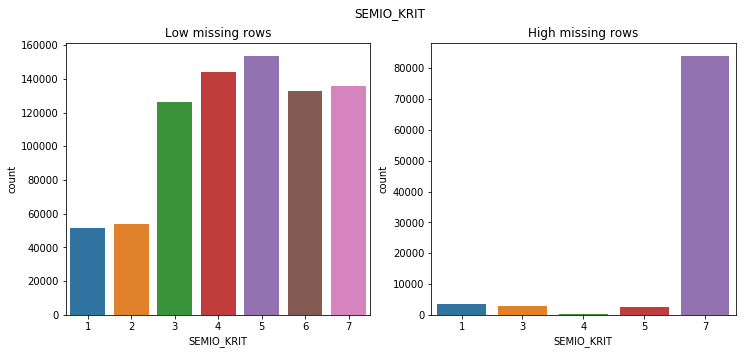

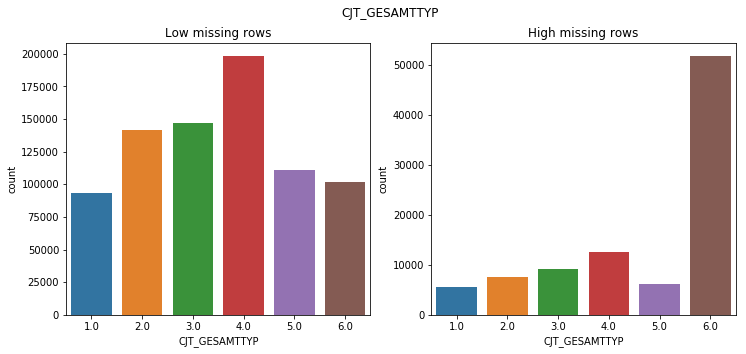

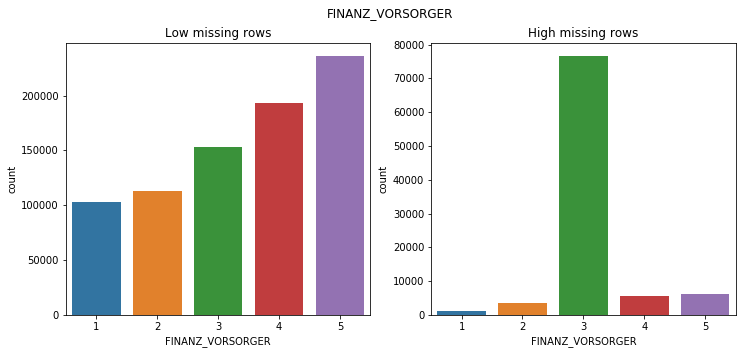

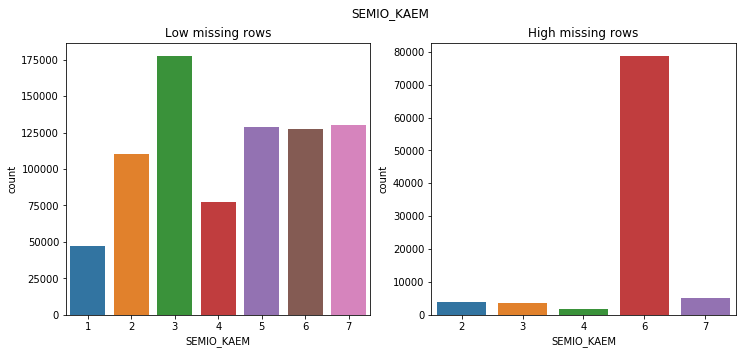

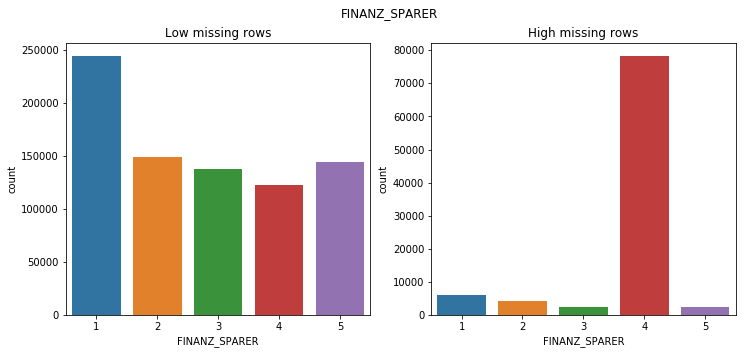

In [28]:
for i in range(5):
    plot_compare(five_low_missing_col[i])

#### Discussion 1.1.3: Assess Missing Data in Each Row

In this section, firstly, I chosse those whose missing value is greater than 40% as high missing data rows because mean + 2sigma contains 90% information, and in this case mean+2sigma is approx 40. Also base on figure `Histgram of percentage of missing data for each row`, we can separate dataset by 40% missing rate. Hence, 40% might be a good  watershed.

Secondly, I randomly choose five columns with  low missing rate. We want to look into if there's any pattern in those columns. As we can see in rows with low missing rate, the distribution is more balanced. However, in those with high missing rate, usually show spike in it. Therefore, more or less, the histograms give us some clues.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which I can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: 'categorical', and 'mixed'.

In the first two parts of this sub-step, I will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether I will keep, drop, or re-encode each. Then, in the last part, I will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once it has been done with this step, I'll be ready to get to the machine learning parts of the project!

In [29]:
# How many features are there of each data type?
# because we drop some columns before, we need to renew the features in feat_info
features = list(azdias.columns.values) # the remains features
feat_info = feat_info[feat_info['attribute'].isin(features)]
feat_info['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, I would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, I can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, I need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), I can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document my choices in the Discussion section.

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_var = feat_info[feat_info['type'] == 'categorical']['attribute'].values
categorical_var = [att for att in categorical_var]
categorical_var_binary = [att for att in categorical_var if azdias[att].nunique() == 2]
categorical_var_multi = [att for att in categorical_var if azdias[att].nunique() > 2]

In [31]:
for att in categorical_var_binary:
    print(att, azdias[att].unique())

ANREDE_KZ [1 2]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ nan   1.   0.]
VERS_TYP [ nan   2.   1.]
OST_WEST_KZ [nan 'W' 'O']


In [32]:
for att in categorical_var_multi:
    print(att, azdias[att].unique())

azdias[categorical_var_multi].nunique()

CJT_GESAMTTYP [  2.   5.   3.   4.   1.   6.  nan]
FINANZTYP [4 1 6 5 2 3]
GFK_URLAUBERTYP [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
LP_FAMILIE_FEIN [  2.   5.   1.  nan  10.   7.  11.   3.   8.   4.   6.   9.]
LP_FAMILIE_GROB [  2.   3.   1.  nan   5.   4.]
LP_STATUS_FEIN [  1.   2.   3.   9.   4.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB [  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ [ nan   1.   3.   2.]
SHOPPER_TYP [ nan   3.   2.   1.   0.]
ZABEOTYP [3 5 4 1 6 2]
GEBAEUDETYP [ nan   8.   1.   3.   2.   6.   4.   5.]
CAMEO_DEUG_2015 [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
CAMEO_DEU_2015 [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
ZABEOTYP             6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

#### My Note: 
1.  `OST_WEST_KZ` with binary categoricals contains non-numeric elements: W and O
2. `CAMEO_DEU_2015` with multi-level categoricals contains 44 non-numeric elements.
I'd remove `CAMEO DEU_2015` because it is too trivial, and then I will re-encode `OST_WEST_KZ`

In [33]:
# Re-encode categorical variable(s) to be kept in the analysis.
categorical_var_multi.remove('CAMEO_DEU_2015')
azdias_low_missing["OST_WEST_KZ"].replace({'O':0, 'W':1}, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [34]:
azdias_low_missing.drop(columns = 'CAMEO_DEU_2015', inplace=True)
azdias_low_missing.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(798067, 79)

In [35]:
azdias_encode = pd.get_dummies(data=azdias_low_missing, columns = categorical_var_multi)
azdias_encode.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1,0,0,0,0,0,0,0,1,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,1,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,1,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0,0,1,0


In [36]:
# Check if there are many "0" in a re-encode column, I'd drop it.
encode_chk_df = pd.DataFrame(data = azdias_low_missing, columns = categorical_var_multi)
encode_chk_df2 = pd.get_dummies(data = encode_chk_df, columns = categorical_var_multi)

# Calculate the percentage of "0" in re-encode columns
zero_number_precent = []
for col in encode_chk_df2.columns:
    zero_number_precent.append(sum(encode_chk_df2[col] == 0)/encode_chk_df2.shape[0]*100)
    
encode_chk_df3 = pd.DataFrame(list(zip(encode_chk_df2.columns, zero_number_precent)))
encode_chk_df3.set_axis(['Feature', 'zero_number_percent'], axis = 1, inplace = True)
encode_chk_df3.head()

,Feature,zero_number_percent
0,CJT_GESAMTTYP_1.0,88.307874
1,CJT_GESAMTTYP_2.0,82.298604
2,CJT_GESAMTTYP_3.0,81.552927
3,CJT_GESAMTTYP_4.0,75.152963
4,CJT_GESAMTTYP_5.0,86.077109


In [37]:
# Select those columns with percentage of "0" > 99% as redundant columns
redundant_col = encode_chk_df3[encode_chk_df3['zero_number_percent'] > 99]['Feature'].values
redundant_col

array(['LP_FAMILIE_FEIN_3.0', 'GEBAEUDETYP_2.0', 'GEBAEUDETYP_4.0',
       'GEBAEUDETYP_5.0', 'GEBAEUDETYP_6.0'], dtype=object)

In [38]:
# Drop 'LP_FAMILIE_FEIN_3.0', 'GEBAEUDETYP_2.0', 'GEBAEUDETYP_4.0', 'GEBAEUDETYP_5.0', 'GEBAEUDETYP_6.0'
# Because they have over 99% non-use values
azdias_encode.drop(['LP_FAMILIE_FEIN_3.0', 'GEBAEUDETYP_2.0', 'GEBAEUDETYP_4.0', 'GEBAEUDETYP_5.0', 'GEBAEUDETYP_6.0'] , axis=1, inplace = True)

In [39]:
azdias_encode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798067 entries, 1 to 891220
Columns: 146 entries, ALTERSKATEGORIE_GROB to CAMEO_DEUG_2015_9
dtypes: float64(43), int64(23), object(1), uint8(79)
memory usage: 494.2+ MB


In [40]:
features_encode = azdias_encode.columns.values
for col in features_encode:
    if azdias_encode[col].dtypes == object:
        print(col)

CAMEO_INTL_2015


In [41]:
feat_info[feat_info['attribute'] == 'CAMEO_INTL_2015']['type'].values

array(['mixed'], dtype=object)

#### Discussion 1.2.1: Re-Encode Categorical Features

1. Firstly, we see  `OST_WEST_KZ` with binary categoricals contains non-numeric elements: W and O. 
2. Secondly, `CAMEO_DEU_2015` with multi-level categoricals contains 44 non-numeric elements. Therefore, I remove `CAMEO DEU_2015` because it is too trivial, and then I re-encode `OST_WEST_KZ` and all of those variables with multi-level categoricals. The result shows in `azdias_encode`.
3. When we look more closely into the `azdias_encode.info()`, we can see there is a `object` variable in our database. After tracking it, I find that the variable is `CAMEO_INTL_2015`, and the type of this variable is "mixed" which we will clean in next step.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to my own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I'd create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [42]:
mixed_var = feat_info[feat_info['type'] == 'mixed']['attribute'].values

for att in mixed_var:
    print(att, azdias_encode[att].unique())

azdias_encode[mixed_var].nunique()

LP_LEBENSPHASE_FEIN [ 21.   3.  nan  32.   8.   2.   5.  10.   4.   6.  23.  12.  20.   1.  11.
  25.  13.  18.  31.  38.  35.  30.   7.  22.  14.  29.  24.  28.  37.  26.
  39.  27.  36.   9.  34.  33.  15.  40.  16.  19.  17.]
LP_LEBENSPHASE_GROB [  6.   1.  nan  10.   2.   3.   5.   7.  12.  11.   9.   4.   8.]
PRAEGENDE_JUGENDJAHRE [ 14.  15.   8.   3.  10.  11.   5.   9.   6.   4.  nan   2.   1.  12.  13.
   7.]
WOHNLAGE [ 4.  2.  7.  3.  5.  1.  8.  0.]
CAMEO_INTL_2015 ['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' nan '25'
 '23' '31' '52' '35' '45' '44' '32']
PLZ8_BAUMAX [  1.   2.  nan   4.   5.   3.]


LP_LEBENSPHASE_FEIN      40
LP_LEBENSPHASE_GROB      12
PRAEGENDE_JUGENDJAHRE    15
WOHNLAGE                  8
CAMEO_INTL_2015          21
PLZ8_BAUMAX               5
dtype: int64

#### My Note:
1. Only `CAMEO_INTL_2015` has non-numeric elements, we'd process it to numerical number later.
2. `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` are all about life stage, wealth and marital status. Other variables already contain those information. Therefore, we'd remove these two features.
3. Look into `PRAEGENDE_JUGENDJAHRE`: I'd create two features to represent this column, 
`PJ_Decade` and `PJ_Movement`. In `PJ_Decade` column: 0 for 40s, 1 for 50s, 2 for 60s and so on. In `PJ_Movement` column: 0 for mainstream and 1 for avantgarde.
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

`PRAEGENDE_JUGENDJAHRE`: Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)


4. Look into `CAMEO_INTL_2015`: I'd create two features to represent wealth and life stage. The 'tens'-place represent wealth, and all the 'ones'-place convert to life stage.

`CAMEO_INTL_2015`: German CAMEO: Wealth / Life Stage Typology, mapped to international code\
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [43]:
# Drop 'LP_LEBENSPHASE_FEIN' and 'LP_LEBENSPHASE_GROB' columns. 
# the reason will be mentioned in following discussion.
print(azdias_encode.shape)
azdias_encode.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'] , axis=1, inplace=True)
print(azdias_encode.shape)

(798067, 146)
(798067, 144)


In [44]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
Decade_dict = {0: [1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9], 4: [10, 11, 12, 13], 5:[14, 15]}
Movement_dict = {0: [1, 3, 5, 8, 10, 12, 14]}

def map_Decade(x):
    try:
        for key, val in Decade_dict.items():
            if x in val:
                return key
    except ValueError:
        return np.nan


def map_Movement(x):
    if pd.isnull(x):
        return np.nan
    else:
        for key, val in Movement_dict.items():
            if x in val:
                return key
            else:
                return 1

In [45]:
azdias_encode['PJ_Decade'] = azdias_encode['PRAEGENDE_JUGENDJAHRE'].apply(map_Decade)
azdias_encode['PJ_Movement'] = azdias_encode['PRAEGENDE_JUGENDJAHRE'].apply(map_Movement)

In [46]:
# double check
print(azdias_encode['PRAEGENDE_JUGENDJAHRE'][:5])
print(azdias_encode['PJ_Decade'][:5])
azdias_encode['PJ_Movement'][:5]

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64
1    5.0
2    5.0
3    3.0
4    3.0
5    1.0
Name: PJ_Decade, dtype: float64


1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
Name: PJ_Movement, dtype: float64

In [47]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def map_Wealth(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[0])

    

def map_Lifestage(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[1])

In [48]:
azdias_encode['CAMEO_INTL_2015_Wealth'] = azdias_encode['CAMEO_INTL_2015'].apply(map_Wealth)
azdias_encode['CAMEO_INTL_2015_Lifestage'] = azdias_encode['CAMEO_INTL_2015'].apply(map_Lifestage)

In [49]:
# double check
print(azdias_encode['CAMEO_INTL_2015'][:5])
print(azdias_encode['CAMEO_INTL_2015_Wealth'][:5])
azdias_encode['CAMEO_INTL_2015_Lifestage'][:5]

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object
1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: CAMEO_INTL_2015_Wealth, dtype: float64


1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: CAMEO_INTL_2015_Lifestage, dtype: float64

In [50]:
# Drop 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' cloumns
azdias_encode = azdias_encode.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)

In [51]:
azdias_encode = pd.get_dummies(data=azdias_encode, columns=['WOHNLAGE', 'PLZ8_BAUMAX'])

In [52]:
# double check
azdias_encode.filter(regex="^WOHNLAGE", axis=1).head()

,WOHNLAGE_0.0,WOHNLAGE_1.0,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0
1,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,1,0


In [53]:
# double check
azdias_encode.filter(regex="^PLZ8_BAUMAX", axis=1).head()

,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0
5,1,0,0,0,0


In [54]:
azdias_encode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798067 entries, 1 to 891220
Columns: 157 entries, ALTERSKATEGORIE_GROB to PLZ8_BAUMAX_5.0
dtypes: float64(42), int64(23), uint8(92)
memory usage: 491.9 MB


#### Discussion 1.2.2: Engineer Mixed-Type Features

1. I drop `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` clumns because they are all about life stage, wealth and marital status. Other variables already contain those information. Therefore, we'd remove these two features.
2. For `PRAEGENDE_JUGENDJAHRE`: I create two features to represent it, `PJ_Decade` and `PJ_Movement`. In `PJ_Decade` column: 0 for 40s, 1 for 50s, 2 for 60s and so on. And, in `PJ_Movement` column: 0 for mainstream and 1 for avantgarde.
3. For `CAMEO_INTL_2015`: I create two features to represent wealth and life stage. The 'tens'-place represent wealth, and all the 'ones'-place convert to life stage.
4. I drop `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` beacuse they won't be used anymore.
5. I re-encode the remains mixed-type columns: `WOHNLAGE` and `PLZ8_BAUMAX`  
6. We can see all data type in `azdias_encode.info()` are numerical number! Finally!

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, I need to make sure that my data frame now only has the columns that I want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that I have engineered, that I've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, I'd not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features I created should be retained. As a reminder, my data should only be from **the subset with few or no missing values**.

## **Have done all engineering, droping, en-coding in step 1.2.2**

### Step 1.3: Create a Cleaning Function

Even though I've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that I'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps I performed above. Then, when it comes to looking at the customer data in Step 3, I can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [55]:
# Function is_int: to check if a variable is int or not
def is_int(value):
  try:
    int(value)
    return True
  except ValueError:
    return False


# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Function map_Decade, map_Movement, map_Wealth and map_Lifestage: to map corresponding values into new feature
def map_Decade(x):
    Decade_dict = {0: [1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9], 4: [10, 11, 12, 13], 5:[14, 15]}
    try:
        for key, val in Decade_dict.items():
            if x in val:
                return key
    except ValueError:
        return np.nan


def map_Movement(x):
    Movement_dict = {0: [1, 3, 5, 8, 10, 12, 14]}
    if pd.isnull(x):
        return np.nan
    else:
        for key, val in Movement_dict.items():
            if x in val:
                return key
            else:
                return 1
            
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def map_Wealth(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[0])

    

def map_Lifestage(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[1])

In [56]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # Load in the feature summary file.
    feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';')
    
    
    # convert missing value codes into NaNs, ...
    for i in range(df.shape[1]):
        att = feat_info.loc[i, 'attribute']
        tmp = feat_info.loc[i, 'missing_or_unknown'].strip('[]').split(',') # output tpye are list of string
        missing_unknow = [int(j) if is_int(j) == True else j for j in tmp] # convert number to int
        df.loc[:, att].replace(missing_unknow, np.nan, inplace = True)
    
    
    # remove selected columns, ...
    nan_col = df.isnull().sum().sort_values(ascending = False)
    nan_table = pd.DataFrame(data = nan_col, columns = ['count'])
    nan_table['percent'] = nan_table['count']/df.shape[0] *100
    outlier_col = nan_table[nan_table['percent'] > 43.95].index
    df.drop(columns = outlier_col, inplace = True)
    
    # select low missing data rows, ...
    nan_row = df.isnull().sum(axis = 1).sort_values(ascending = False)
    nan_table2 = pd.DataFrame(data = nan_row, columns = ['count'])
    nan_table2['percent'] = nan_table2['count']/df.shape[1] *100
    df_low_missing = df[nan_table2['percent'] < 40]

    # refresh the remain features:
    features = list(df.columns.values) # the remains features
    feat_info = feat_info[feat_info['attribute'].isin(features)]
    
    # select, re-encode, and engineer column values. (type: categorical)
    categorical_var = feat_info[feat_info['type'] == 'categorical']['attribute'].values
    categorical_var = [att for att in categorical_var]
    categorical_var_multi = [att for att in categorical_var if df[att].nunique() > 2]
    
    df_low_missing["OST_WEST_KZ"].replace({'O':0, 'W':1}, inplace = True)
    df_low_missing.drop(columns = 'CAMEO_DEU_2015', inplace = True)
    categorical_var_multi.remove('CAMEO_DEU_2015')
    df_encode = pd.get_dummies(data = df_low_missing, columns = categorical_var_multi)
    df_encode.drop(['LP_FAMILIE_FEIN_3.0', 'GEBAEUDETYP_2.0', 'GEBAEUDETYP_4.0', 'GEBAEUDETYP_5.0', 'GEBAEUDETYP_6.0'] , 
                   axis=1, inplace = True, errors = 'ignore')
    
    # select, re-encode, and engineer column values. (type: mixed)
    df_encode.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'] , axis = 1, inplace = True)
    df_encode['PJ_Decade'] = df_encode['PRAEGENDE_JUGENDJAHRE'].apply(map_Decade)
    df_encode['PJ_Movement'] = df_encode['PRAEGENDE_JUGENDJAHRE'].apply(map_Movement)
    df_encode['CAMEO_INTL_2015_Wealth'] = df_encode['CAMEO_INTL_2015'].apply(map_Wealth)
    df_encode['CAMEO_INTL_2015_Lifestage'] = df_encode['CAMEO_INTL_2015'].apply(map_Lifestage)
    
    # Drop 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' cloumns
    df_encode = df_encode.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis = 1)
    
    # re-encode
    df_encode = pd.get_dummies(data = df_encode, columns=['WOHNLAGE', 'PLZ8_BAUMAX'])
    
    # Return the cleaned dataframe.
    return df_encode
    

In [57]:
# Double check
azdias_chk = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')
azdias_chk2 = clean_data(azdias_chk)
azdias_chk2.equals(azdias_encode)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


True

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, I'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help me navigate to all of the classes and functions that I'll need. In this substep, I'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to my data, make sure that I've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. I might also try a more complicated procedure where I temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data I have and what possible effects each approach might have on my analysis, and justify my decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, I can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since I'll be applying them to the customer demographics data towards the end of the project.

In [58]:
# Must clean all NaN values before next step.
# I'd Using the most frequent value to replace NaN
azdias_clean = azdias_encode.copy()
imputer = Imputer(missing_values = np.nan, strategy = "most_frequent", axis = 1)
azdias_clean = pd.DataFrame(imputer.fit_transform(azdias_clean))
azdias_clean.head()

,0,1,2,3,4,5,6,7,8,9,...,147,148,149,150,151,152,153,154,155,156
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [59]:
# double check if there's any NaN
azdias_clean.isnull().sum().sum()

0

In [60]:
# Apply feature scaling to the general population demographics data.
azdias_clean_scaled = pd.DataFrame(StandardScaler().fit_transform(azdias_clean))

In [61]:
azdias_clean_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,147,148,149,150,151,152,153,154,155,156
0,-1.733620,0.957912,-1.494594,1.537920,-1.040686,1.465965,0.958633,1.339319,-0.530407,1.037380,...,-0.674835,2.206650,-0.320511,-0.518933,-0.149609,0.773028,-0.311060,-0.260545,-0.276509,-0.372695
1,0.208165,0.957912,-1.494594,0.864560,-1.766972,-0.570999,0.244109,1.339319,1.885345,1.037380,...,-0.674835,-0.453176,-0.320511,-0.518933,-0.149609,0.773028,-0.311060,-0.260545,-0.276509,-0.372695
2,1.179057,0.957912,0.683145,-0.482159,1.138172,-0.570999,-1.184938,-0.791197,-0.530407,-0.112479,...,-0.674835,-0.453176,-0.320511,1.927031,-0.149609,0.773028,-0.311060,-0.260545,-0.276509,-0.372695
3,0.208165,-1.043937,0.683145,0.191200,0.411886,-1.249987,0.244109,-0.791197,-0.530407,1.037380,...,1.481843,-0.453176,-0.320511,-0.518933,-0.149609,-1.293615,3.214818,-0.260545,-0.276509,-0.372695
4,-1.733620,0.957912,-0.042768,-1.155519,1.138172,-0.570999,-0.470414,1.339319,-0.530407,1.037380,...,-0.674835,-0.453176,-0.320511,1.927031,-0.149609,0.773028,-0.311060,-0.260545,-0.276509,-0.372695


#### Discussion 2.1: Apply Feature Scaling

1. Firstly, I replace NaN using the most frequent number for each column. Some choose mean or median, but I think that people are sort of following the "bandwagon effect". Therefore, my strategy is "most_frequent".
2. After impute NaN, I standardise the whole dataframe to make sure all columns achieve a mean of 0 and std of 1.

### Step 2.2: Perform Dimensionality Reduction

On my scaled data, I'm now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, I'd not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what I find, select a value for the number of transformed features I'll retain for the clustering part of the project.
- After choosing for the number of components to keep, I'd re-fit a PCA instance to perform the decided-on transformation.

In [62]:
azdias_clean_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798067 entries, 0 to 798066
Columns: 157 entries, 0 to 156
dtypes: float64(157)
memory usage: 955.9 MB


In [63]:
# Apply PCA to the data.
pca = PCA(n_components = 100)
azdias_pca = pca.fit_transform(azdias_clean_scaled)

In [64]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        if(i % 20 == 0):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width = 0)
    ax.yaxis.set_tick_params(width = 2, length = 12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


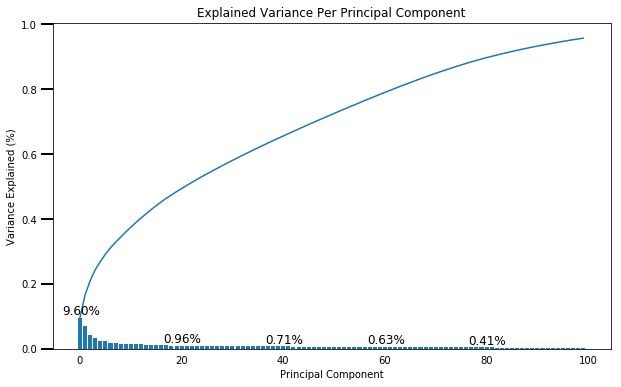

In [65]:
fig1 = scree_plot(pca)

In [66]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_cumvals = np.cumsum(pca.explained_variance_ratio_)
n_comp = (np.where(pca_cumvals > 0.8))[0][0]
pca = PCA(n_comp)
azdias_pca = pca.fit_transform(azdias_clean_scaled)

We choose 62 as our n_components for PCA


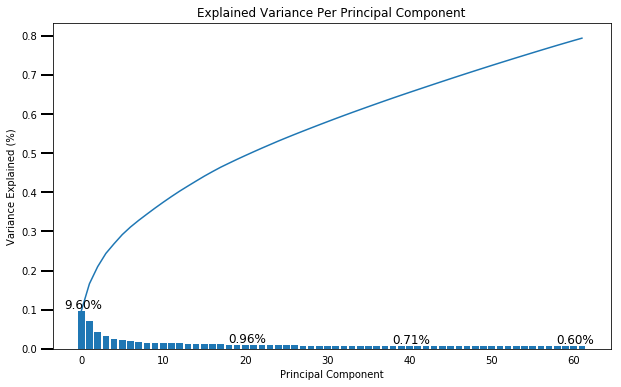

In [67]:
print("We choose {} as our n_components for PCA".format(n_comp))
fig2 = scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

As we can see in fig1, the cumulative variance reached 80% when the number of principal component is around 60. In order to be more accurate, I pick out the number from PCA model parameters, and the specific principal component is 62. Therefore, I'd use 62 as the n_component for further analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, I'd map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help me understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- I'd investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, I'd write a function that I can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when I interpret the tendencies of the discovered clusters.

In [68]:
def plot_pca_weights(df, pca, nth_comp):
    feat_name = list(azdias_encode.columns)
    weights = list(pca.components_[nth_comp])
    df = pd.DataFrame(list(zip(feat_name, weights)))
    df.set_axis(['Feature', 'Weights'], axis = 1, inplace = True)
    df = df.sort_values(by = ['Weights'], ascending = False)
    df2 = pd.concat([df.head(5), df.tail(5)])
    df2.set_index('Feature', inplace = True)
    
    df2.plot(kind = 'bar', fontsize = 12)
    ax = plt.gca()
    ax.set_title(str(nth_comp) + 'th Component', fontsize = 25)
    ax.grid(linewidth = '0.5', alpha = 0.5)
    plt.show()
    return df2.index.values

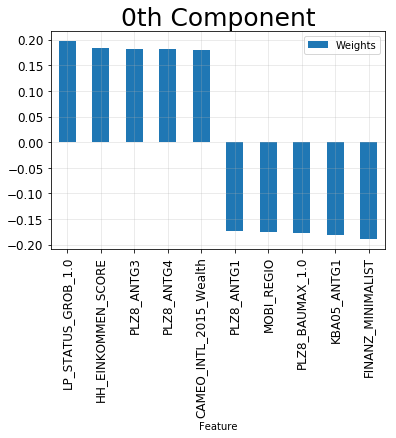

In [69]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_0th = plot_pca_weights(azdias_encode, pca, 0)


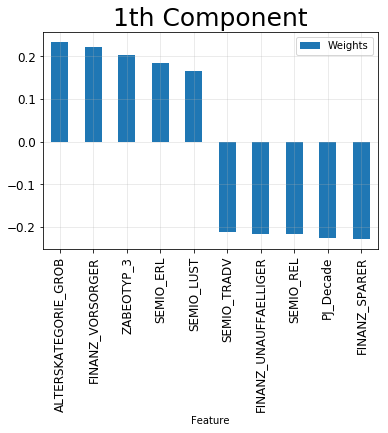

In [70]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_1th = plot_pca_weights(azdias_encode, pca, 1)


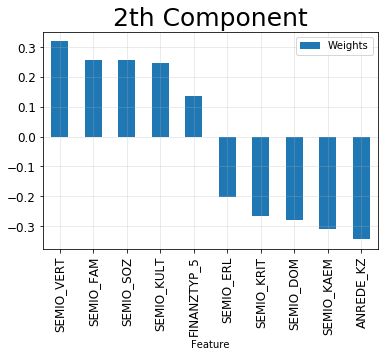

In [71]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_2th = plot_pca_weights(azdias_encode, pca, 2)

### Discussion 2.3: Interpret Principal Components

#### The 0th Component:
- Top 2 with positive weighing:
 1. LP_STATUS_GROB_1.0: Social status, low income group
 2. HH_EINKOMMEN_SCORE: Estimated household net income
- Top 2 with negative weighing:
 1. FINANZ_MINIMALIST: Financial typology, low financial interest
 2. KBA05_ANTG1: Number of 1-2 family houses in the microcell
 
#### The 1th Component:
- Top 2 with positive weighing:
 1. ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
 2. FINANZ_VORSORGER: Financial typology, be prepared
- Top 2 with negative weighing:
 1. FINANZ_SPARER: Financial typology, money-saver
 2. PJ_Decade: decade features in PRAEGENDE_JUGENDJAHRE
 
#### The 2th Component:
- Top 2 with positive weighing:
 1. SEMIO_VERT: Personality typology, dreamful
 2. SEMIO_FAM: Personality typology, family-minded
- Top 2 with negative weighing:
 1. ANREDE_KZ: Gender
 2. SEMIO_KAEM: Personality typology, combative attitude

#### Conclusion: 
It is clear that the most influential feature is about financial status, and then about age and personality. Therefore, 0th component is related to individual income, and th component is linked to age, decade of movement, and 3th component is regarded to personaly traits and gender.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

I've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, I will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help my understanding.
- Perform the above two steps for a number of different cluster counts. I can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. I'd test for cluster counts through at least 10 clusters to get the full picture, but we should not need to test for a number of clusters above about 30.
- Once I've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that I also obtain the cluster assignments for the general demographics data, since I'll be using them in the final Step 3.3.

In [72]:
# Random sampling data from original dataset to reduce computational cost
sample_idx = np.random.choice(azdias_pca.shape[0], int(azdias_pca.shape[0]*0.2), replace = False)
azdias_pca_sample = azdias_pca[sample_idx]
azdias_pca_sample.shape

(159613, 62)

In [73]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
scores = []
for centre in range(2, 30):
    start = time.time()
    kmeans = KMeans(centre)
    model = kmeans.fit(azdias_pca_sample)
    scores.append(abs(model.score(azdias_pca_sample))/azdias_pca_sample.shape[0])
    print(f"# of clusters: {centre}.. "
          f"Average within-cluster distances {scores[centre-2]:.3f} | "
          f"During: {time.time() - start:.3f} sec")
    

# of clusters: 2.. Average within-cluster distances 113.034 | During: 6.400 sec
# of clusters: 3.. Average within-cluster distances 107.633 | During: 9.877 sec
# of clusters: 4.. Average within-cluster distances 103.885 | During: 14.734 sec
# of clusters: 5.. Average within-cluster distances 100.878 | During: 14.800 sec
# of clusters: 6.. Average within-cluster distances 98.998 | During: 14.757 sec
# of clusters: 7.. Average within-cluster distances 97.169 | During: 21.609 sec
# of clusters: 8.. Average within-cluster distances 95.654 | During: 21.169 sec
# of clusters: 9.. Average within-cluster distances 93.833 | During: 23.013 sec
# of clusters: 10.. Average within-cluster distances 92.525 | During: 26.369 sec
# of clusters: 11.. Average within-cluster distances 91.279 | During: 28.669 sec
# of clusters: 12.. Average within-cluster distances 90.530 | During: 34.809 sec
# of clusters: 13.. Average within-cluster distances 89.776 | During: 37.201 sec
# of clusters: 14.. Average within

Text(0,0.5,'Average Distance From Centroid')

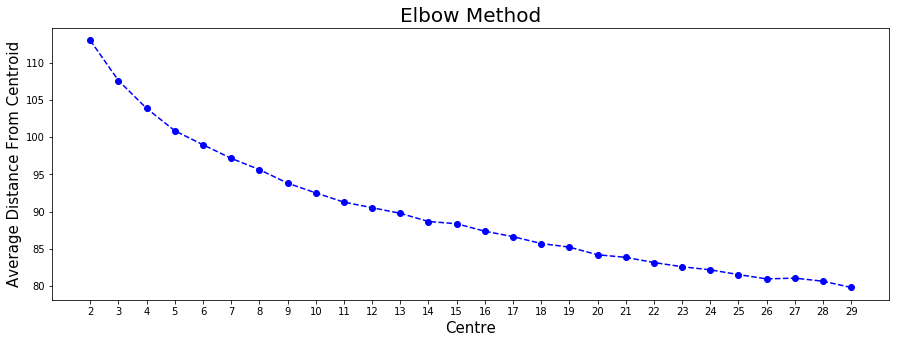

In [103]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
centres = list(range(2, 30))
avg_d = [i for i in scores]
plt.figure(figsize = (15, 5))
plt.plot(centres, avg_d, linestyle = '--', marker = 'o', color = 'b')
plt.xticks(np.arange(2, 30, 1))
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Centre', fontsize = 15)
plt.ylabel('Average Distance From Centroid', fontsize = 15)


In [75]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

k = 15
kmeans = KMeans(n_clusters = k)
model = kmeans.fit(azdias_pca)
azdias_cluster = model.predict(azdias_pca)
azdias_cluster

array([ 5,  4, 13, ...,  9,  7, 12], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

I finally choose 15 as my k value for KMeans model. Even if there's no obvious elbow curve in the plot, we still can easly calculate that from k = 2 to k = 15, the average within-cluster distance reduced 22%, but from k = 15 to k = 29, this distance only went down 10%. Therefore, 15 should be a good choice to our KMeans model.

### Step 3.2: Apply All Steps to the Customer Data

Now that I have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, I'm going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, I will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function I created earlier. (We can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, we should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should we be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [76]:
# Load in the customer demographics data.
customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', sep = ';')
customers.shape

(191652, 85)

In [77]:
# Clean customer data
customers = clean_data(customers)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [78]:
# Impute NaN as most_frequent value
imputer = Imputer(missing_values = np.nan, strategy = "most_frequent", axis = 1)
customers_clean = pd.DataFrame(imputer.fit_transform(customers))
customers_clean.head()

,0,1,2,3,4,5,6,7,8,9,...,147,148,149,150,151,152,153,154,155,156
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [79]:
# Apply feature scaling to the customer data.
scaler = StandardScaler()
customers_clean_scaled = pd.DataFrame(scaler.fit_transform(customers_clean))

In [80]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_pca = pca.transform(customers_clean_scaled)


In [81]:
# Predict clustering
customers_cluster = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, I will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis I performed in step 1.1.3 of the project, where I separated out certain data points from the dataset if they had more than a specified threshold of missing values. If I found that this group was qualitatively different from the main bulk of the data, I'd treat this as an additional data cluster in this analysis. Make sure that we account for the number of data points in this subset, for both the general population and customer datasets, when making my computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help me make this inference. Alternatively, we can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [83]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
demographics_prop = []
customer_prop = []

for i in range(k):
    demographics_prop.append((azdias_cluster == i).sum()/len(azdias_cluster))
    customer_prop.append((customers_cluster == i).sum()/len(customers_cluster))

clusters = [i for i in range(k)]
df_compare = pd.DataFrame({'Cluster': clusters, 'Demographics': demographics_prop, 'Customers': customer_prop})


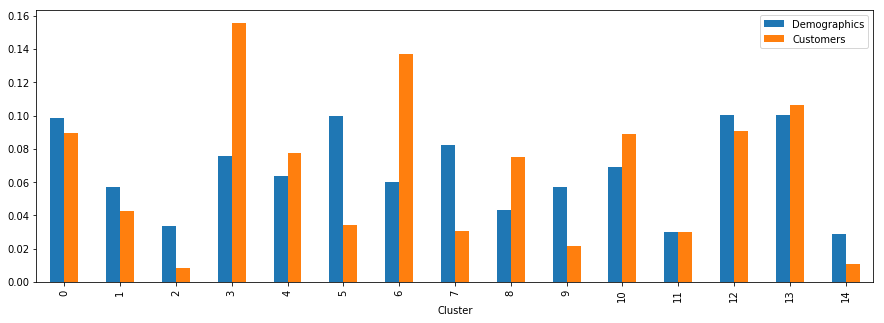

In [84]:
df_compare.plot(x = 'Cluster', y = ['Demographics', 'Customers'], kind = 'bar', figsize = (15, 5))

In [113]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cust_over_demo = [i for i in range(k) if (customer_prop[i]/demographics_prop[i] >= 1.5)]
print('Cluster', cust_over_demo, 'are overrepresented')

Cluster [3, 6, 8] are overrepresented


In [111]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cust_under_demo = [i for i in range(k) if (demographics_prop[i]/customer_prop[i] >= 1.5)]
print('Cluster', cust_under_demo, 'are underrepresented')

Cluster [2, 5, 7, 9, 14] are underrepresented


In [100]:
# Look into overrepresented group
cluster_over = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(customers_cluster==3)])).round(), columns=customers.columns)

# Look into underrepresented group
cluster_under = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(customers_cluster==5)])).round(), columns=customers.columns)


In [101]:
# The most frequent values from each columns in overrepresented group
cluster_over[pca_0th].mode()

,LP_STATUS_GROB_1.0,HH_EINKOMMEN_SCORE,PLZ8_ANTG3,PLZ8_ANTG4,CAMEO_INTL_2015_Wealth,PLZ8_ANTG1,MOBI_REGIO,PLZ8_BAUMAX_1.0,KBA05_ANTG1,FINANZ_MINIMALIST
0,0.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,5.0


In [115]:
cluster_over[pca_1th].mode()

,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,ZABEOTYP_3,SEMIO_ERL,SEMIO_LUST,SEMIO_TRADV,FINANZ_UNAUFFAELLIGER,SEMIO_REL,PJ_Decade,FINANZ_SPARER
0,4.0,5.0,0.0,5.0,6.0,2.0,2.0,3.0,1.0,1.0


In [117]:
cluster_over[pca_2th].mode()

,SEMIO_VERT,SEMIO_FAM,SEMIO_SOZ,SEMIO_KULT,FINANZTYP_5,SEMIO_ERL,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,ANREDE_KZ
0,7.0,4.0,5.0,4.0,0.0,5.0,3.0,3.0,2.0,1.0


In [102]:
# The most frequent values from each columns in underrepresented group
cluster_under[pca_0th].mode()

,LP_STATUS_GROB_1.0,HH_EINKOMMEN_SCORE,PLZ8_ANTG3,PLZ8_ANTG4,CAMEO_INTL_2015_Wealth,PLZ8_ANTG1,MOBI_REGIO,PLZ8_BAUMAX_1.0,KBA05_ANTG1,FINANZ_MINIMALIST
0,1.0,5.0,2.0,1.0,4.0,1.0,1.0,0.0,-0.0,2.0


### Discussion 3.3: Compare Customer Data to Demographics Data

#### My response:
#### 1. It is clear that the major proportion of customer segment could be represented by the clusters 3, 6, 8. Those people in the three clusters are the our target, or say the company's target customer.
#### 2.  Look into more detail in the overrepresented group, we can see the composition of our target is:
- LP_STATUS_GROB_1.0 = 0, means high-income
- HH_EINKOMMEN_SCORE = 2, means very high income
- PLZ8_ANTG3 = 1, lower share of 6-10 family homes
- MOBI_REGIO = 4, means low movement
- FINANZ_MINIMALIST = 5, means very low financial interest
- ALTERSKATEGORIE_GROB = 4, means >60 years old
- FINANZ_SPARER = 1, means money save very high
- SEMIO_VERT = 7, means lowest affinity in dreamful personality
- ANREDE_KZ = 1, means male
- and so on ...

#### All these point out that our target should be:
- Very confident in their financial status
- Low mobility
- Elder
- Male
- Pragmatic personality